In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

1. Yang+07 identifier (NYU_VAGC) vs. SDSS DR7 identifier
2. Bottrell+19 identifier matching with (1)

### Load SDSS DR7 Group catalog (Yang+07)

group catalog

In [2]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

grps['col1'].name = 'id'
grps['col2'].name = 'RA'
grps['col3'].name = 'dec'
grps['col4'].name = 'z'
grps['col5'].name = 'L'
grps['col6'].name = 'sm'
grps['col7'].name = 'hm1'
grps['col8'].name = 'hm2'
grps['col9'].name = 'mean_sep1'
grps['col10'].name = 'mean_sep2'
grps['col11'].name = 'f_edge'
grps['col12'].name = 'ID1'
grps['col13'].name = 'ID2'

# groups (1) massive than 2e12 M* (2) 0.015 < z < 0.055 (3) Stripe 82 survey area
mask_m = (grps['hm1'] > np.log10(2e12))
mask_z = (grps['z'] > 0.015) & (grps['z'] < 0.055)
mask_coord = ((grps['RA'] < 70) | (grps['RA'] > 290)) & ((grps['dec'] < 1.5) & (grps['dec'] > -1.5))
mask_grp = mask_m & mask_z & mask_coord

grps = grps[mask_grp]


In [3]:
# ra_grp = grps['RA']
# dec_grp = grps['dec']
# zz_grp = grps['z']
# dist_grp = cosmo.comoving_distance(zz_grp).value # Mpc

# coords = SkyCoord(ra = ra_grp * u.degree, dec = dec_grp * u.degree, distance = dist_grp * u.Mpc)

# x_grp = coords.cartesian.x
# y_grp = coords.cartesian.y
# z_grp = coords.cartesian.z

member catalog

In [ ]:
#  1. group id; 
#  2. member galaxy id in NYU_VAGC
#  3. member galaxy id in SDSS7?
grps_mems = Table.read('./data/group_DR7/imodelA_2', format = 'ascii')

mask = np.isin(grps_mems['col1'], grps['id'])
grps_mems = grps_mems[mask]

### Load SDSS DR7 catalog

In [ ]:
# col  1: galaxy ID
# col  2: NYU-VAGC ID : object ID (row in NYU-VAGC files)
# col  3: ra 
# col  4: dec
# col  5: z redshift
# col  6: apparent magnitude r_band (SDSS magnitude)
# col  7: magnitude limit r_band
# col  8: completeness in this region
# col  9: ^{0.1}M_r-5\log h  (K+E corrected to z=0.1) -- Petro
# col 10: ^{0.1}(g-r)  color (K+E corrected to z=0.1) -- Petro
# col 11: ^{0.1}M_r-5\log h  (K+E corrected to z=0.1) -- Model
# col 12: ^{0.1}(g-r)  color (K+E corrected to z=0.1) -- Model
# col 13: redshift source type: 1 SDSS; 2 other; 3 KSG-VAGC; 4 nearest 
#         5 from X-ray clusters (last 30)
#         * for those with negtive values (469), photometries are update
#           according to their parents. 
dr7 = Table.read('./data/galaxy_DR7/SDSS7', format = 'ascii')

# 1. Identifier matching between Yang+07 and SDSS DR7

In [ ]:
mask = np.isin(dr7['col2'], grps_mems['col2'])
dr7_cands = dr7[mask]

In [ ]:
# save results
dr7_cands.write('./data/galaxy_DR7/SDSS7_matched.cat', format = 'ascii')

# 2. Crossmatching (coords) between (1) and Stripe82 (Bottrell+82)

### Load Stripe82

In [36]:
cat = Table.read("./data/s82grfn.fit")

ra_gal = cat['RAJ2000'].value
dec_gal = cat['DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

### coordinates

In [39]:
coords_dr7 = SkyCoord(ra = dr7_cands['col3'] * u.degree, dec = dr7_cands['col4'] * u.degree)

coords_s82 = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree)

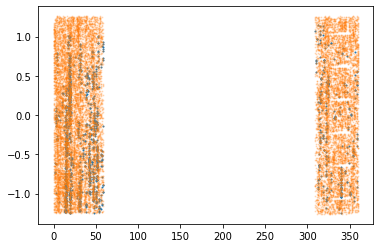

In [42]:
plt.scatter(dr7_cands['col3'], dr7_cands['col4'], s = 1)
plt.scatter( ra_gal, dec_gal, s = 1, alpha = .2)

### x-matching

In [45]:
from astropy.coordinates import match_coordinates_sky


In [46]:
idx, d2d, d3d = match_coordinates_sky(coords_dr7, coords_s82)

max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep

### Save results

In [73]:
tbl = Table()

tbl['ds7_col2'] = dr7_cands[sep_constraint]['col2']
tbl['s82_recno'] = cat[idx[sep_constraint]]['recno']

tbl.write('./data/galaxy_DR7/SDSS7_S82_matched_id.cat', format = 'ascii')